In [1]:
%matplotlib inline

import time

# math and data manipulation
import numpy as np
import pandas as pd
from tqdm import tqdm

# to handle paths
from pathlib import Path

# set random seeds 
from numpy.random import seed
from tensorflow import set_random_seed
from tensorflow import keras

from csef.model import lstm
from csef.data import preprocessing, load_data
from csef.utils import performance
from csef.model.base import GeneralModel

RANDOM_SEED = 2018
seed(RANDOM_SEED)
set_random_seed(RANDOM_SEED)

## Data Loading

In [2]:
data_mapping = load_data.load_data()
consumption_train = data_mapping['consumption_train']
cold_start_test = data_mapping['cold_start_test']
submission_format = data_mapping['submission_format']
meta = data_mapping['meta']

## Training

In [3]:
load_data.describe_training_data(consumption_train)

There are 758 training series totaling 21224 days (509376 hours) of consumption data.


In [17]:
# Default config
n_batch = 1
n_input = 24
n_nodes = 24
lag = n_input
batch_input_shape = (n_batch, 1, n_input)

### Baseline model but go with 40 epoches 

In [5]:
config = {
    'n_input': n_input,
    'n_nodes': n_nodes,
    'n_batch': n_batch,
    'model': [
        {
            'layer_type': 'LSTM',
            'layer_config': {
                'units': n_input,
                'batch_input_shape': batch_input_shape,
                'stateful': True
            }
        },
        {
            'layer_type': 'Dense',
            'layer_config': {
                'units': 1
            }
        }
    ]
}

In [6]:
model = GeneralModel(config)

In [ ]:
num_training_series = consumption_train.series_id.nunique()
num_passes_through_data = 40

total_start_time = time.time()

epoch_timers = []

for i in range(num_passes_through_data):
    epoch_start_time = time.time()
    model.fit(consumption_train)
    epoch_timers.append((epoch_start_time, time.time()))
    
total_end_time = time.time()

Fitting the data:  71%|███████   | 540/758 [15:14<06:09,  1.69s/it]

In [12]:
total_end_time - total_start_time

51361.016990184784

In [ ]:
my_submission = model.make_submission(submission_format, cold_start_test)

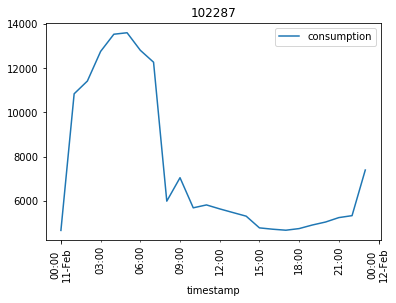

In [13]:
# plot samples
sample_ser = (my_submission[my_submission.prediction_window == 'hourly']
                           .series_id
                           .sample().values[0])

(my_submission[my_submission.series_id == sample_ser]
              .plot(x='timestamp',
                    y='consumption',
                    title=sample_ser,
                    rot=90))

In [14]:
save_path = Path('..', '..', 'data', 'submissions')
save_path.mkdir(exist_ok=True, parents=True)
my_submission.to_csv(save_path / "release-004-01-20181023.csv", index_label='pred_id')

model_path = Path('..', '..', 'data', 'model')
model_path.mkdir(exist_ok=True, parents=True)
keras.models.save_model(
    model.model,
    model_path / 'release-004-01-20181024.hdf5'
)

LB: 0.4901

## Fix the submission

In [39]:
my_model = keras.models.load_model(model_path / 'release-004-01-20181024.hdf5')

In [40]:
def generate_hourly_forecast(num_pred_hours, df, model, scaler, lag):
    """ Uses last hour's prediction to generate next for num_pred_hours, 
        initialized by most recent cold start prediction. Inverts scale of 
        predictions before return.
    """
    # allocate prediction frame
    preds_scaled = np.zeros(num_pred_hours)
    
    # initial X is last lag values from the cold start
    X = scaler.transform(df.values.reshape(-1, 1))[-n_input:]
        
    # forecast
    for i in range(num_pred_hours):
        # predict scaled value for next time step
        X = np.flip(X.ravel(), axis=0)
        yhat = model.predict(X.reshape(1, 1, n_input), batch_size=1)[0][0]
        preds_scaled[i] = yhat
        
        # update X to be latest data plus prediction
        X = pd.Series(X.ravel()).shift(-1).fillna(yhat).values
        
    # revert scale back to original range
    hourly_preds = scaler.inverse_transform(preds_scaled.reshape(-1, 1)).ravel()
    return hourly_preds

In [ ]:
my_submission_df = submission_format.copy()

pred_window_to_num_preds = {'hourly': 24, 'daily': 7, 'weekly': 2}
pred_window_to_num_pred_hours = {'hourly': 24, 'daily': 7 * 24, 'weekly': 2 * 7 * 24}

num_test_series = my_submission_df['series_id'].nunique()

model.reset_states()

for ser_id, pred_df in tqdm(my_submission_df.groupby('series_id'),
                            total=num_test_series,
                            desc="Forecasting from Cold Start Data"):
    # get info about this series' prediction window
    pred_window = pred_df.prediction_window.unique()[0]
    num_preds = pred_window_to_num_preds[pred_window]
    num_pred_hours = pred_window_to_num_pred_hours[pred_window]

    # prepare cold start data
    series_data = cold_start_test[cold_start_test['series_id'] == ser_id]['consumption']
    cold_X, cold_y, scaler = preprocessing.prepare_training_data(series_data, n_input)

    # fine tune our lstm model to this site using cold start data
    my_model.fit(cold_X, cold_y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)

    # make hourly forecasts for duration of pred window
    preds = generate_hourly_forecast(num_pred_hours, series_data, my_model, scaler, lag)

    # reduce by taking sum over each sub window in pred window
    reduced_preds = [pred.sum() for pred in np.split(preds, num_preds)]

    # store result in submission DataFrame
    ser_id_mask = my_submission_df['series_id'] == ser_id
    my_submission_df.loc[ser_id_mask, 'consumption'] = reduced_preds

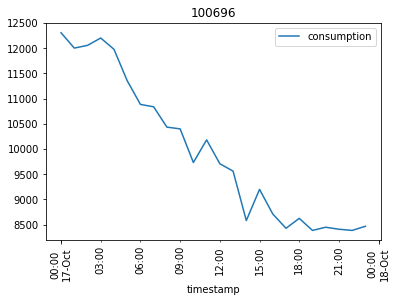

In [42]:
# plot samples
sample_ser = (my_submission[my_submission.prediction_window == 'hourly']
                           .series_id
                           .sample().values[0])

(my_submission[my_submission.series_id == sample_ser]
              .plot(x='timestamp',
                    y='consumption',
                    title=sample_ser,
                    rot=90))

In [43]:
save_path = Path('..', '..', 'data', 'submissions')
save_path.mkdir(exist_ok=True, parents=True)
my_submission.to_csv(save_path / "release-004-02-20181024.csv", index_label='pred_id')

model_path = Path('..', '..', 'data', 'model')
model_path.mkdir(exist_ok=True, parents=True)
keras.models.save_model(
    model.model,
    model_path / 'release-004-02-20181024.hdf5'
)